In [ ]:
!pip install openmeteo_requests
!pip install pandas
!pip install numpy
!pip install matplotlib.pyplot
!pip install geopandas
!pip install requests_cache
!pip install random
!pip install retry_requests
!pip install shapely.geometry
!pip install cartiflette
!pip install cartopy


In [3]:
import random
import openmeteo_requests
import requests_cache
from retry_requests import retry
import geopandas as gpd
from cartiflette import carti_download
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import numpy as np


In [ ]:

# Télécharger les frontières de la France métropolitaine avec cartiflette
france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Transformer la France en un GeoDataFrame avec uniquement la France métropolitaine
france_gdf = france[france["INSEE_REG"] > 10]  # Exclure les régions d'outre-mer


def generate_random_points_in_france(num_points=50):
    points = []
    # Obtenir la géométrie de la France métropolitaine
    france_geom = france_gdf.unary_union  # Fusionner toutes les géométries pour simplifier la vérification

    # Générer des points aléatoires jusqu'à ce qu'ils soient dans la France métropolitaine
    while len(points) < num_points:
        lat = random.uniform(41.0, 51.0)  # Latitude approximée
        lon = random.uniform(-5.0, 9.0)   # Longitude approximée
        point = Point(lon, lat)  # Créer un point avec shapely
        if france_geom.contains(point):  # Vérifier si le point est dans la France
            points.append((lat, lon))

    return points


# Générer les points
random_points = generate_random_points_in_france(50)

# Afficher les points générés
for idx, (lat, lon) in enumerate(random_points, start=1):
    print(f"Point {idx}: Latitude = {lat:.6f}, Longitude = {lon:.6f}")

In [5]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

def temperature_random_points(nb_points : int) -> pd.DataFrame  :
    # Liste des points aléatoires (exemple avec 2 points, étendre à 100 points)
    random_points = generate_random_points_in_france(nb_points)

    # Date unique pour la requête (remplacez par la date souhaitée)
    date = "2024-12-02"

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Créer un DataFrame consolidé pour stocker les résultats
    dataframes = []

    # Effectuer une requête pour chaque point
    for idx, (latitude, longitude) in enumerate(random_points, start=1):
        print(f"Traitement du point {idx}: Latitude = {latitude}, Longitude = {longitude}")

        # Paramètres de la requête pour chaque point
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "hourly": "temperature_2m",
            "start_date": date,
            "end_date": date,
            "models": "meteofrance_seamless"
        }

        try:
            # Effectuer la requête Open-Meteo
            responses = openmeteo.weather_api("https://api.open-meteo.com/v1/forecast", params=params)
            response = responses[0]

            # Extraire les données horaires pour la température à 2m
            hourly = response.Hourly()
            hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

            hourly_data = {
                "date": pd.date_range(
                    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                    freq=pd.Timedelta(seconds=hourly.Interval()),
                    inclusive="left"
                ),
                "temperature_2m": hourly_temperature_2m
            }

            # Ajouter la latitude et la longitude aux données
            hourly_data["latitude"] = latitude
            hourly_data["longitude"] = longitude

            # Convertir en DataFrame et ajouter à la liste
            df = pd.DataFrame(data=hourly_data)
            dataframes.append(df)

        except Exception as e:
            print(f"Erreur lors du traitement du point {idx}: {e}")

    # Consolider tous les DataFrames
    final_dataframe = pd.concat(dataframes, ignore_index=True)

    # Sauvegarder les résultats dans un fichier CSV
    final_dataframe.to_csv("weather_data.csv", index=False)

    result = final_dataframe.loc[final_dataframe["date"] == "2024-12-02 00:00:00+00:00"].rename(columns = {'temperature_2m' : 'temperature'})
    
    
    return result


In [ ]:
result = temperature_random_points(200)

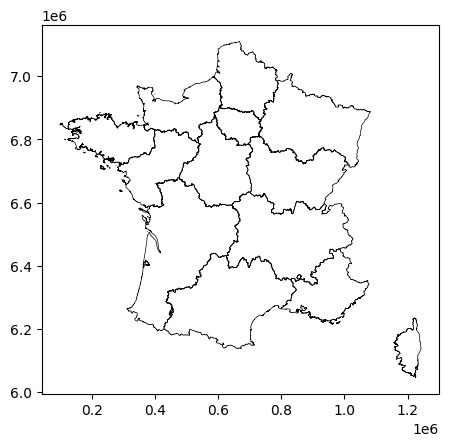

In [7]:
from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
france = france.loc[france["INSEE_REG"] > 10]
france_2154 = france.to_crs(2154)
ax1 = france_2154.boundary.plot(edgecolor="k", linewidth=0.5)

In [9]:
result.head()

,date,temperature,latitude,longitude
0,2024-12-02 00:00:00+00:00,8.400000,43.836923,0.602019
24,2024-12-02 00:00:00+00:00,6.291000,45.477633,2.655608
48,2024-12-02 00:00:00+00:00,11.269500,48.191612,-2.726451
72,2024-12-02 00:00:00+00:00,8.402000,48.320570,4.518057
96,2024-12-02 00:00:00+00:00,8.106501,48.987585,4.647650


C:\Users\Tristan\AppData\Local\Temp\ipykernel_9608\3005951258.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_geom = france_gdf.unary_union  # Fusionner toutes les géométries pour simplifier la vérification


Traitement du point 1: Latitude = 43.83692334896964, Longitude = 0.6020186402748937
Traitement du point 2: Latitude = 45.47763340904593, Longitude = 2.65560827084715
Traitement du point 3: Latitude = 48.19161168388442, Longitude = -2.726451168462866
Traitement du point 4: Latitude = 48.320570069850646, Longitude = 4.518057191721688
Traitement du point 5: Latitude = 48.98758488015748, Longitude = 4.647649729539825
Traitement du point 6: Latitude = 46.59238469318622, Longitude = 1.6000714273513017
Traitement du point 7: Latitude = 49.59460438159292, Longitude = 4.188061744095279
Traitement du point 8: Latitude = 46.776314657357624, Longitude = 1.0696316025956314
Traitement du point 9: Latitude = 44.30559841809639, Longitude = 6.657412596158174
Traitement du point 10: Latitude = 50.72689004687131, Longitude = 2.7835240129116103
Traitement du point 11: Latitude = 45.672588500676696, Longitude = 3.1229791946849463
Traitement du point 12: Latitude = 48.34863273058006, Longitude = 4.919587573

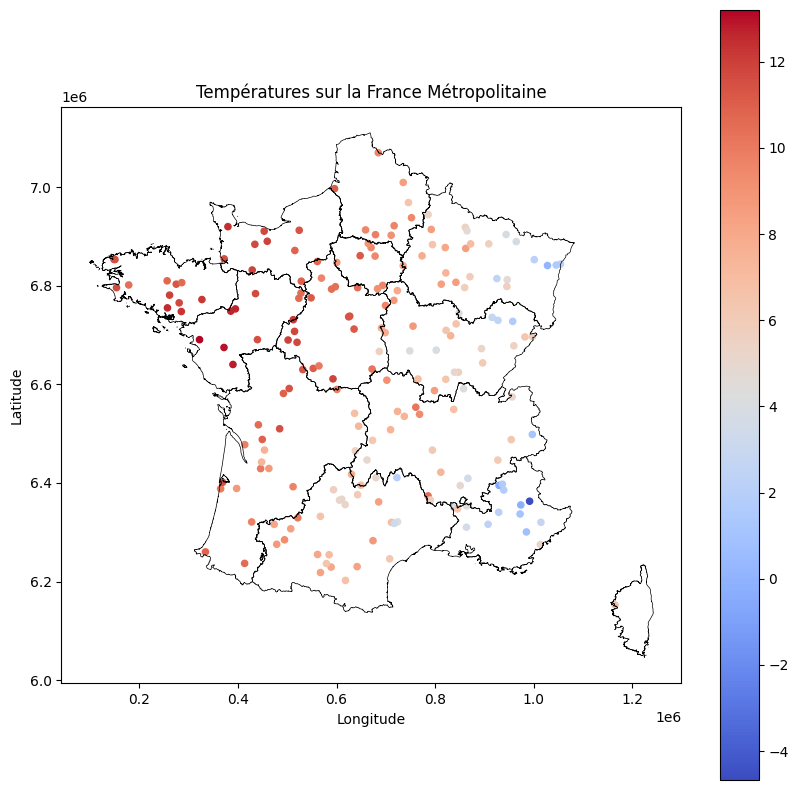

In [8]:
result = temperature_random_points(200)

# Exemple avec 100 points aléatoires
np.random.seed(42)
num_points = 100
random_lats = 43 + np.random.rand(num_points) * 8  # Aléatoire dans les latitudes autour de la France métropolitaine
random_lons = -5 + np.random.rand(num_points) * 15  # Aléatoire dans les longitudes autour de la France métropolitaine
random_temps = np.random.rand(num_points) * 15  # Valeurs de température entre 0 et 15°C

# Créer le DataFrame avec les températures
result 

# Convertir le DataFrame pandas en GeoDataFrame avec la projection EPSG:4326
geometry = [Point(xy) for xy in zip(result["longitude"], result["latitude"])]
geo_result = gpd.GeoDataFrame(result, geometry=geometry, crs="EPSG:4326")

# Reprojections de vos points en Lambert-93 (pour correspondre à france_2154)
geo_result_2154 = geo_result.to_crs(2154)

# Afficher la carte avec la France et les températures sur celle-ci
fig, ax = plt.subplots(figsize=(10, 10))

# Afficher les frontières de la France métropolitaine
france_2154.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)

# Afficher les points de température sur la carte
# Utiliser une couleur pour représenter la température
geo_result_2154.plot(ax=ax, column="temperature", cmap="coolwarm", markersize=20, legend=True)

# Afficher la carte avec les légendes
plt.title("Températures sur la France Métropolitaine")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



In [10]:
print("test")

test


In [1]:
print('ceci est visible seulement dans la branche Tristan')

ceci est visible seulement dans la branche Tristan
